In [1]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import yfinance as yf
import vectorbt as vbt
from datetime import datetime, timedelta

In [2]:
data = pd.DataFrame()
data = data.ta.ticker(
     "AAPL",
     start=datetime(2021, 3, 1),
     end=datetime(2021, 3, 15),
     interval='1h'
)
data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
2021-03-01 09:30:00-05:00,123.500000,125.250000,122.790001,125.084999,30763287,0,0
2021-03-01 10:30:00-05:00,125.084999,126.154999,124.880096,125.879898,15870701,0,0
2021-03-01 11:30:00-05:00,125.879997,126.620003,125.789902,126.230003,13509856,0,0
2021-03-01 12:30:00-05:00,126.239998,126.400002,125.669998,126.209297,8484702,0,0
2021-03-01 13:30:00-05:00,126.205002,127.230003,126.089996,127.105003,11084566,0,0
...,...,...,...,...,...,...,...
2021-03-12 12:30:00-05:00,120.849800,121.070000,120.427002,120.896698,8122057,0,0
2021-03-12 13:30:00-05:00,120.889999,121.010002,120.500000,120.589996,6602156,0,0
2021-03-12 14:30:00-05:00,120.595001,120.900002,120.464996,120.754997,7340616,0,0
2021-03-12 15:30:00-05:00,120.760002,121.169998,120.680000,121.040100,7978422,0,0


In [71]:
orders = pd.DataFrame({
        'price_action': [1.04999, 10, 1.04775, 10, 10],
        'entries': [True, False, False, False, False],
        'exits': [False, False, True, False, False],
        'lots': [0.03*10**5, np.nan, np.nan, np.nan, np.nan] # 0 is close order, np.nan is skip
    }
    ,index=[datetime(2022, 1, 1) + timedelta(days=i) for i in range(5)])
orders

,price_action,entries,exits,lots
2022-01-01,1.04999,True,False,3000.0
2022-01-02,10.00000,False,False,NaN
2022-01-03,1.04775,False,True,NaN
2022-01-04,10.00000,False,False,NaN
2022-01-05,10.00000,False,False,NaN


In [72]:
port = vbt.Portfolio.from_signals(orders.price_action,
                                  entries=orders.entries,
                                  exits=orders.exits,
                                  size=orders.lots,
                                  freq="D",
                                  init_cash=10000,
#                                   fees=0.0025, 
#                                   slippage=0.0025
                                 )

In [73]:
port.plot().show()

<AxesSubplot:>

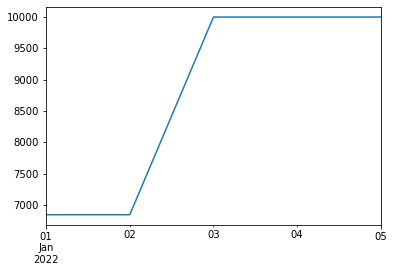

In [74]:
port.cash().plot()

In [75]:
port.stats()

Start                         2022-01-01 00:00:00
End                           2022-01-05 00:00:00
Period                            5 days 00:00:00
Start Value                               10000.0
End Value                                 9993.28
Total Return [%]                          -0.0672
Benchmark Return [%]                   852.390023
Max Gross Exposure [%]                   81.41106
Total Fees Paid                               0.0
Max Drawdown [%]                        72.881216
Max Drawdown Duration             3 days 00:00:00
Total Trades                                    1
Total Closed Trades                             1
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                                  0.0
Best Trade [%]                          -0.213335
Worst Trade [%]                         -0.213335
Avg Winning Trade [%]                         NaN
Avg Losing Trade [%]                    -0.213335


In [76]:
# Fees = Size * Price * fees , This Fees for lot size
# Avg Entry Price = price_action + (price_action * Slippage) = price_action * (1 + Slippage)
# Slippage = (Avg Entry Price / price_action) - 1
# Avg Exit Price = price_action - (price_action * Slippage) = price_action * (1 - Slippage)

port.orders.records_readable

,Order Id,Column,Timestamp,Size,Price,Fees,Side
0,0,0,2022-01-01,3000.0,1.04999,0.0,Buy
1,1,0,2022-01-03,3000.0,1.04775,0.0,Sell


In [77]:
2*10.025*0.0025

0.050125

In [78]:
# Size = Lot size
# Cash entry side = Cash - (size * Avg Entry Price + Entry Fees)
# Cash exit side = Cash + (size * Avg Exit Price - Exit Fees)
# Cash order entry side = (size * Price) + (Size * Price * fees) = size * (Price + (Price * fees)) = size * (Price * (1+fees))
# Cash order exit side = (size * Price) - (Size * Price * fees) = size * (Price - (Price * fees)) = size * (Price * (1-fees))
# size = taget entry cash / (Price * (1 + fees))
# PnL = (Size * Avg Entry Price + Entry Fees) - (Size * Avg Exit Price - Exit Fees)
# Entry Fees + Exit Fees = PnL - Size * Avg Entry Price + Size * Avg Exit Price = PnL - Size*(Avg Entry Price - Avg Exit Price)

port.trades.records_readable

,Exit Trade Id,Column,Size,Entry Timestamp,Avg Entry Price,Entry Fees,Exit Timestamp,Avg Exit Price,Exit Fees,PnL,Return,Direction,Status,Position Id
0,0,0,3000.0,2022-01-01,1.04999,0.0,2022-01-03,1.04775,0.0,-6.72,-0.002133,Long,Closed,0


In [21]:
(1.04999 - 1.04775)/0.0001*10*0.03

6.720000000000059

In [24]:
(0.03*(1.04999-1.04775))

6.720000000000059e-05

In [63]:
104999*0.03

3149.97

In [12]:
port.cash()

2022-01-01    69.849813
2022-01-02    69.849813
2022-01-03    99.700000
2022-01-04    99.700000
2022-01-05    99.700000
dtype: float64

In [271]:
stats = port.stats()
print(stats['Win Rate [%]'])
print(stats['Avg Losing Trade [%]'])

0.0
-0.9975062344139369


In [4]:
data = pd.read_csv('xtb_trades.csv')
data.tail()

,Symbol;Position;Type;Lots;Open time;Open price;Close time;Close price;Profit;Net profit;Rollover;Comment
72,GBPUSD;513726846;Sell Limit;0.04;06.01.2022 15...
73,EURUSD;513722654;Sell Stop;0.04;06.01.2022 15:...
74,EURUSD;512787088;Buy Limit;0.04;05.01.2022 16:...
75,EURUSD;511460226;Sell Limit;0.04;03.01.2022 22...
76,EURUSD;511044910;Buy Limit;0.04;03.01.2022 13:...


In [2]:
with open('xtb_trades.csv') as file:
    lines = file.readlines()
    f = open("trade_hist.csv", "w")
    for line in lines:
        f.write(line.replace(';', ','))
        f.write('\n')
    f.close()

In [3]:
data = pd.read_csv('trade_hist.csv')
data.tail()

,Symbol,Position,Type,Lots,Open time,Open price,Close time,Close price,Profit,Net profit,Rollover,Comment
72,GBPUSD,513726846,Sell Limit,0.04,06.01.2022 15:08:53,1.35005,06.01.2022 15:47:15,1.34978,1.08,1.08,0,[T/P]
73,EURUSD,513722654,Sell Stop,0.04,06.01.2022 15:05:44,1.12889,06.01.2022 15:09:32,1.12970,-3.24,-3.24,0,[S/L]
74,EURUSD,512787088,Buy Limit,0.04,05.01.2022 16:52:53,1.13096,05.01.2022 18:33:22,1.13195,3.96,3.96,0,[T/P]
75,EURUSD,511460226,Sell Limit,0.04,03.01.2022 22:07:46,1.13052,03.01.2022 22:27:09,1.12994,2.32,2.32,0,[T/P]
76,EURUSD,511044910,Buy Limit,0.04,03.01.2022 13:59:28,1.13441,03.01.2022 17:03:35,1.13572,5.24,5.24,0,[T/P]


In [75]:
p = 1.038
a = 1.03872
(a/p)-1

0.000693641618497054

In [14]:
0.00021135555769058456
-9.523809523803717e-05
0.000693641618497054

0.0006936416184971617

In [15]:
(a-p) * 100 / p

0.02113555576905649

In [ ]:
0.06936416184971618 % => 0.000693
-0.009523809523808475 %
0.02113555576905649 %

In [16]:
0.00014 * 100 / 1.0147 # 0.001

0.013797181432935842

In [102]:
pnl = -6.72
entry = 1.04999
exit = 1.04775
size = 0.03
pip = 0.0001
pip_value = 10
pnl - size*entry + size*exit

-6.7200672

In [103]:
((entry - exit) / pip ) * pip_value*size # net profit

6.720000000000059

In [104]:
pnl / (((entry - exit) / pip ) * pip_value) # size

-0.029999999999999732